# Experiment Results Visualization

This notebook provides interactive visualizations for VN (Vector Native) vs NL (Natural Language) comparison experiments.

**Usage:**
```bash
# From the experiments directory:
jupyter notebook notebooks/visualize_results.ipynb
```


In [1]:
# ============================================================================
# IMPORTS AND SETUP
# ============================================================================
import sys
from pathlib import Path

# Add parent directory to path for imports
sys.path.insert(0, str(Path.cwd().parent))

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Configure matplotlib for high-quality output
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

from protocols.storage import SpecimenStorage

print("✓ Imports successful")


✓ Imports successful


## Configuration

Set the specimen path you want to visualize:


In [2]:
# ============================================================================
# CONFIGURATION - Set your specimen path here
# ============================================================================

# Available specimens (update these paths as needed)
SPECIMENS_DIR = Path.cwd().parent / "specimens"

# List available specimens
print("Available specimens:")
for specimen in sorted(SPECIMENS_DIR.iterdir()):
    if specimen.is_dir() and not specimen.name.startswith('.'):
        runs = list((specimen / "runs").glob("*/metrics.parquet")) if (specimen / "runs").exists() else []
        print(f"  • {specimen.name} ({len(runs)} runs)")


Available specimens:
  • 2024_12_20_vn_comprehensive_experiments (0 runs)
  • 2025_12_20_hallucination_biopsy_gemma2 (0 runs)
  • 2025_12_20_vn_noise_robustness (1 runs)
  • 2025_12_22_vn_comprehensive_experiments (2 runs)
  • 2025_12_22_vn_convergence_velocity (0 runs)
  • 2025_12_22_vn_extended-metrics (0 runs)
  • 2025_12_22_vn_extended_metrics (2 runs)


In [3]:
# ============================================================================
# SELECT SPECIMEN TO VISUALIZE
# ============================================================================

# Default to extended_metrics for full visualization support
# Change this to "2025_12_22_vn_comprehensive_experiments" if you only want basic metrics
SPECIMEN_NAME = "2025_12_22_vn_extended_metrics"  # Has all columns for figures 1-9

specimen_path = SPECIMENS_DIR / SPECIMEN_NAME
storage = SpecimenStorage(specimen_path)

# Load data from latest run
df = storage.read_metrics()

print(f"\n📊 Loaded specimen: {SPECIMEN_NAME}")
print(f"   Records: {len(df):,}")
print(f"   Columns: {len(df.columns)}")
print(f"\nColumn names:")
for col in df.columns:
    print(f"   • {col}: {df[col].dtype}")



📊 Loaded specimen: 2025_12_22_vn_extended_metrics
   Records: 75
   Columns: 38

Column names:
   • case_id: String
   • category: String
   • complexity: String
   • description: String
   • nl_tokens: Int64
   • vn_tokens: Int64
   • token_ratio: Float64
   • nl_purity: Float64
   • vn_purity: Float64
   • purity_improvement_pct: Float64
   • nl_recon_loss_mean: Float64
   • vn_recon_loss_mean: Float64
   • recon_improvement_pct: Float64
   • nl_recon_loss_std: Float64
   • vn_recon_loss_std: Float64
   • nl_relative_error: Float64
   • vn_relative_error: Float64
   • nl_l0_mean: Float64
   • vn_l0_mean: Float64
   • nl_l0_fraction: Float64
   • vn_l0_fraction: Float64
   • nl_l1_mean: Float64
   • vn_l1_mean: Float64
   • nl_topk_10: Float64
   • vn_topk_10: Float64
   • nl_topk_50: Float64
   • vn_topk_50: Float64
   • nl_topk_100: Float64
   • vn_topk_100: Float64
   • nl_topk_500: Float64
   • vn_topk_500: Float64
   • nl_features_per_token: Float64
   • vn_features_per_token: F

---

# 1. Purity Comparison (Core Metric)


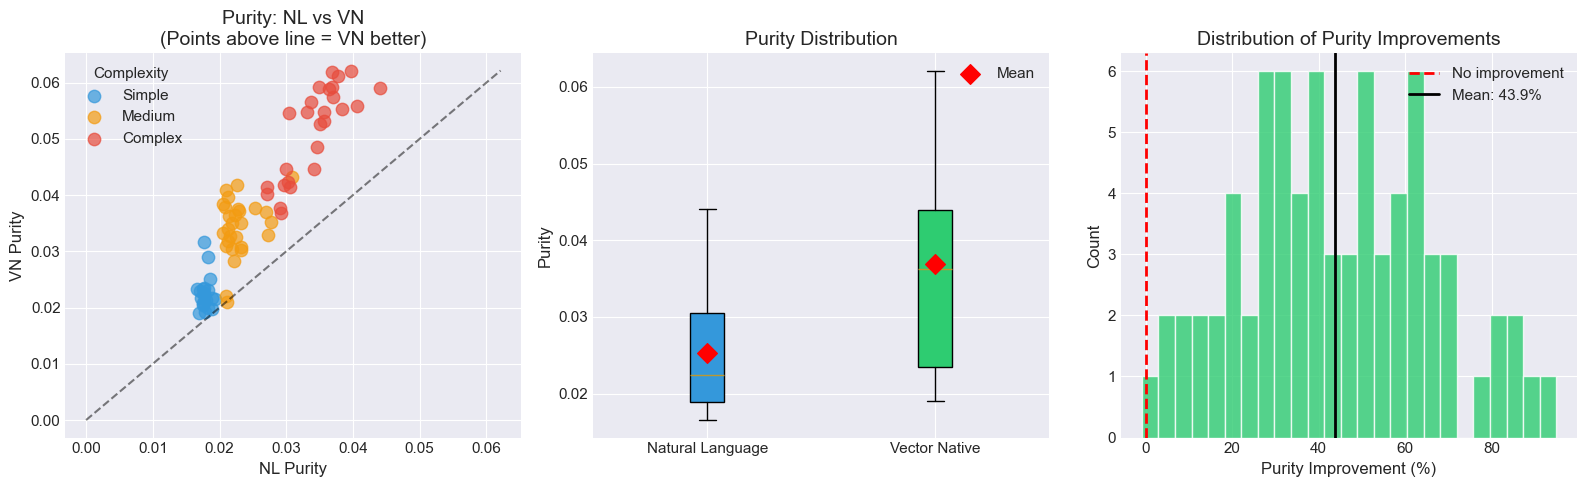


📈 Statistical Summary:
   NL Purity Mean: 0.0254 ± 0.0073
   VN Purity Mean: 0.0369 ± 0.0130
   Paired t-test: t=14.760, p=9.49e-24
   Mean Improvement: 45.6%


In [4]:
# ============================================================================
# FIGURE 1: PURITY COMPARISON (NL vs VN)
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1a. Scatter plot: NL purity vs VN purity
ax1 = axes[0]
nl_purity = df['nl_purity'].to_numpy()
vn_purity = df['vn_purity'].to_numpy()

# Color by complexity if available
if 'complexity' in df.columns:
    complexity = df['complexity'].to_list()
    colors = {'simple': '#3498db', 'medium': '#f39c12', 'complex': '#e74c3c'}
    for comp in ['simple', 'medium', 'complex']:
        mask = [c == comp for c in complexity]
        ax1.scatter(
            nl_purity[mask], vn_purity[mask],
            c=colors[comp], label=comp.capitalize(), alpha=0.7, s=80
        )
    ax1.legend(title='Complexity')
else:
    ax1.scatter(nl_purity, vn_purity, alpha=0.7, s=80)

# Add diagonal reference line
max_val = max(nl_purity.max(), vn_purity.max())
ax1.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Equal purity')
ax1.set_xlabel('NL Purity')
ax1.set_ylabel('VN Purity')
ax1.set_title('Purity: NL vs VN\n(Points above line = VN better)')

# 1b. Box plot comparison
ax2 = axes[1]
box_data = [nl_purity, vn_purity]
bp = ax2.boxplot(box_data, tick_labels=['Natural Language', 'Vector Native'], patch_artist=True)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#2ecc71')
ax2.set_ylabel('Purity')
ax2.set_title('Purity Distribution')

# Add means as diamonds
means = [nl_purity.mean(), vn_purity.mean()]
ax2.scatter([1, 2], means, marker='D', s=100, c='red', zorder=5, label='Mean')
ax2.legend()

# 1c. Improvement histogram
ax3 = axes[2]
if 'purity_improvement_pct' in df.columns:
    improvement = df['purity_improvement_pct'].to_numpy()
    ax3.hist(improvement, bins=25, color='#2ecc71', edgecolor='white', alpha=0.8)
    ax3.axvline(0, color='red', linestyle='--', linewidth=2, label='No improvement')
    ax3.axvline(improvement.mean(), color='black', linestyle='-', linewidth=2, label=f'Mean: {improvement.mean():.1f}%')
    ax3.set_xlabel('Purity Improvement (%)')
    ax3.set_ylabel('Count')
    ax3.set_title('Distribution of Purity Improvements')
    ax3.legend()

plt.tight_layout()
plt.savefig('fig1_purity_comparison.png', bbox_inches='tight', facecolor='white')
plt.show()

# Statistical test
t_stat, p_value = stats.ttest_rel(vn_purity, nl_purity)
print(f"\n📈 Statistical Summary:")
print(f"   NL Purity Mean: {nl_purity.mean():.4f} ± {nl_purity.std():.4f}")
print(f"   VN Purity Mean: {vn_purity.mean():.4f} ± {vn_purity.std():.4f}")
print(f"   Paired t-test: t={t_stat:.3f}, p={p_value:.2e}")
print(f"   Mean Improvement: {((vn_purity.mean() - nl_purity.mean()) / nl_purity.mean() * 100):.1f}%")


# 2. Category Analysis


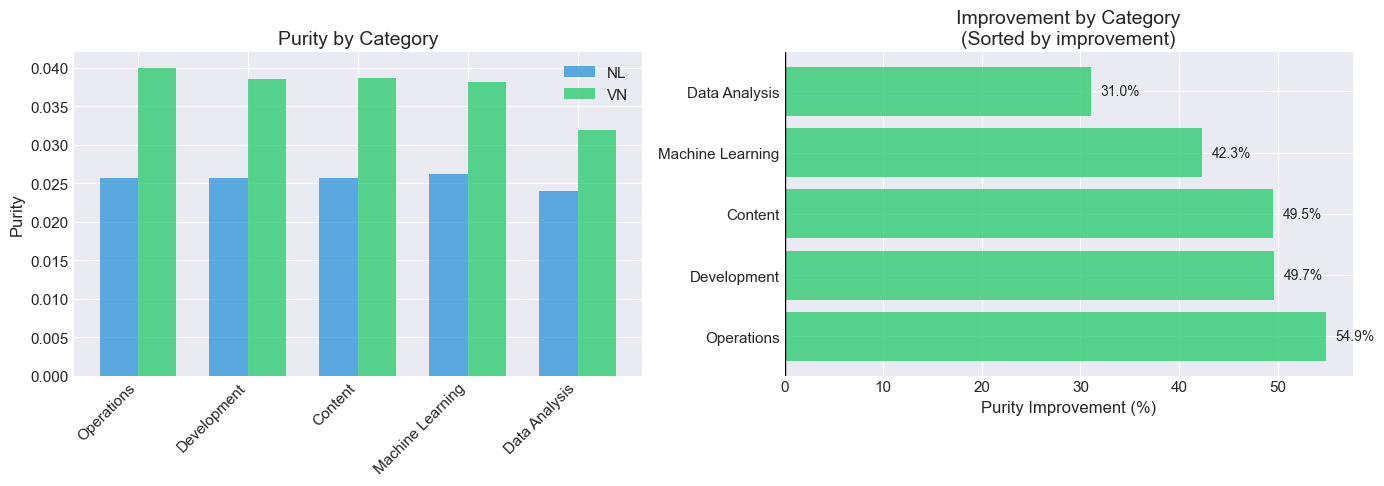

In [5]:
# ============================================================================
# FIGURE 2: BY CATEGORY
# ============================================================================

if 'category' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Get unique categories
    categories = df['category'].unique().to_list()
    
    # 2a. Grouped bar chart - purity by category
    ax1 = axes[0]
    cat_stats = []
    for cat in categories:
        cat_df = df.filter(pl.col('category') == cat)
        cat_stats.append({
            'category': cat,
            'nl_purity': cat_df['nl_purity'].mean(),
            'vn_purity': cat_df['vn_purity'].mean(),
            'improvement': cat_df['purity_improvement_pct'].mean() if 'purity_improvement_pct' in df.columns else 0
        })
    
    cat_stats = sorted(cat_stats, key=lambda x: x['improvement'], reverse=True)
    cat_names = [c['category'].replace('_', ' ').title() for c in cat_stats]
    
    x = np.arange(len(categories))
    width = 0.35
    
    nl_vals = [c['nl_purity'] for c in cat_stats]
    vn_vals = [c['vn_purity'] for c in cat_stats]
    
    bars1 = ax1.bar(x - width/2, nl_vals, width, label='NL', color='#3498db', alpha=0.8)
    bars2 = ax1.bar(x + width/2, vn_vals, width, label='VN', color='#2ecc71', alpha=0.8)
    
    ax1.set_ylabel('Purity')
    ax1.set_title('Purity by Category')
    ax1.set_xticks(x)
    ax1.set_xticklabels(cat_names, rotation=45, ha='right')
    ax1.legend()
    
    # 2b. Improvement by category
    ax2 = axes[1]
    improvements = [c['improvement'] for c in cat_stats]
    colors = ['#2ecc71' if imp > 0 else '#e74c3c' for imp in improvements]
    
    bars = ax2.barh(cat_names, improvements, color=colors, alpha=0.8)
    ax2.axvline(0, color='black', linewidth=1)
    ax2.set_xlabel('Purity Improvement (%)')
    ax2.set_title('Improvement by Category\n(Sorted by improvement)')
    
    # Add value labels
    for bar, imp in zip(bars, improvements):
        x_pos = bar.get_width() + 1 if imp > 0 else bar.get_width() - 1
        ax2.text(x_pos, bar.get_y() + bar.get_height()/2, f'{imp:.1f}%',
                 va='center', ha='left' if imp > 0 else 'right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('fig2_category_analysis.png', bbox_inches='tight', facecolor='white')
    plt.show()
else:
    print("No 'category' column found in data")


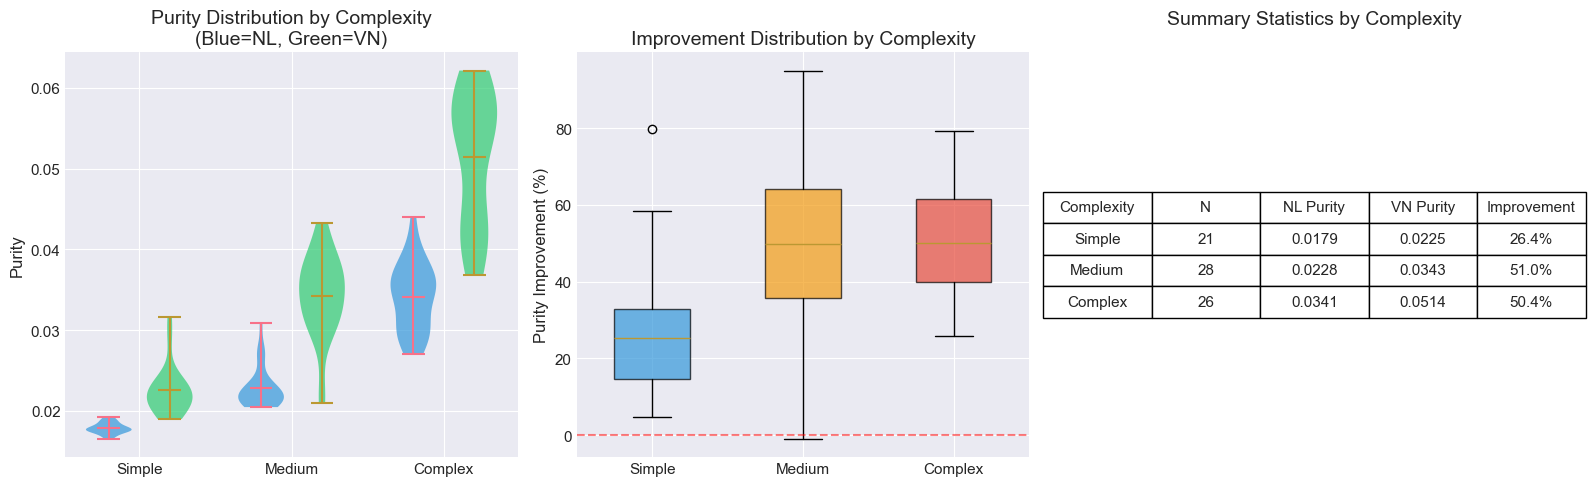

In [6]:
# ============================================================================
# FIGURE 3: BY COMPLEXITY
# ============================================================================

if 'complexity' in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    complexity_order = ['simple', 'medium', 'complex']
    colors_cmp = {'simple': '#3498db', 'medium': '#f39c12', 'complex': '#e74c3c'}
    
    # 3a. Violin plot of purity by complexity
    ax1 = axes[0]
    
    # Prepare data for violin plot
    violin_data_nl = []
    violin_data_vn = []
    labels = []
    
    for comp in complexity_order:
        comp_df = df.filter(pl.col('complexity') == comp)
        if len(comp_df) > 0:
            violin_data_nl.append(comp_df['nl_purity'].to_numpy())
            violin_data_vn.append(comp_df['vn_purity'].to_numpy())
            labels.append(comp.capitalize())
    
    positions_nl = np.arange(len(labels)) * 2
    positions_vn = np.arange(len(labels)) * 2 + 0.8
    
    vp1 = ax1.violinplot(violin_data_nl, positions=positions_nl, widths=0.6, showmeans=True)
    for pc in vp1['bodies']:
        pc.set_facecolor('#3498db')
        pc.set_alpha(0.7)
    
    vp2 = ax1.violinplot(violin_data_vn, positions=positions_vn, widths=0.6, showmeans=True)
    for pc in vp2['bodies']:
        pc.set_facecolor('#2ecc71')
        pc.set_alpha(0.7)
    
    ax1.set_xticks(np.arange(len(labels)) * 2 + 0.4)
    ax1.set_xticklabels(labels)
    ax1.set_ylabel('Purity')
    ax1.set_title('Purity Distribution by Complexity\n(Blue=NL, Green=VN)')
    
    # 3b. Improvement vs Complexity
    ax2 = axes[1]
    if 'purity_improvement_pct' in df.columns:
        for comp in complexity_order:
            comp_df = df.filter(pl.col('complexity') == comp)
            if len(comp_df) > 0:
                imp = comp_df['purity_improvement_pct'].to_numpy()
                bp = ax2.boxplot([imp], positions=[complexity_order.index(comp)], widths=0.5,
                               patch_artist=True, boxprops=dict(facecolor=colors_cmp[comp], alpha=0.7))
        
        ax2.set_xticks(range(len(complexity_order)))
        ax2.set_xticklabels([c.capitalize() for c in complexity_order])
        ax2.set_ylabel('Purity Improvement (%)')
        ax2.set_title('Improvement Distribution by Complexity')
        ax2.axhline(0, color='red', linestyle='--', alpha=0.5)
    
    # 3c. Summary stats table
    ax3 = axes[2]
    ax3.axis('off')
    
    table_data = [['Complexity', 'N', 'NL Purity', 'VN Purity', 'Improvement']]
    for comp in complexity_order:
        comp_df = df.filter(pl.col('complexity') == comp)
        if len(comp_df) > 0:
            table_data.append([
                comp.capitalize(),
                str(len(comp_df)),
                f"{comp_df['nl_purity'].mean():.4f}",
                f"{comp_df['vn_purity'].mean():.4f}",
                f"{comp_df['purity_improvement_pct'].mean():.1f}%" if 'purity_improvement_pct' in df.columns else 'N/A'
            ])
    
    table = ax3.table(cellText=table_data[1:], colLabels=table_data[0],
                      loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 1.8)
    ax3.set_title('Summary Statistics by Complexity', fontsize=14, pad=20)
    
    plt.tight_layout()
    plt.savefig('fig3_complexity_analysis.png', bbox_inches='tight', facecolor='white')
    plt.show()
else:
    print("No 'complexity' column found in data")


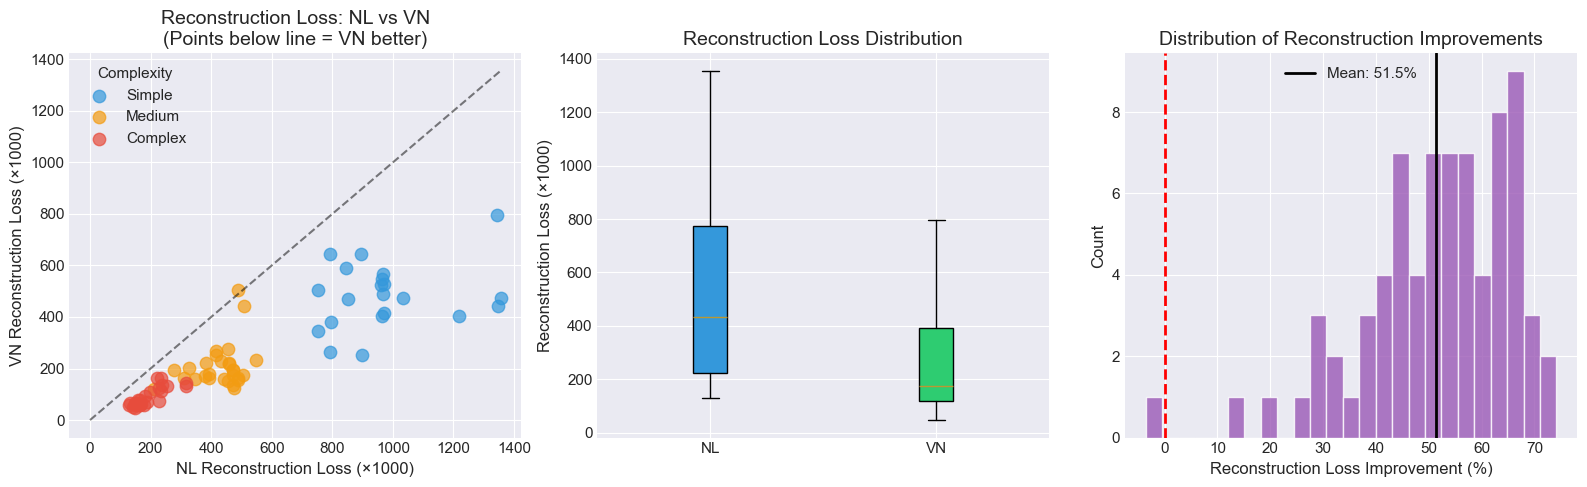


📈 Reconstruction Loss Summary:
   NL Mean: 498,447 ± 332,144
   VN Mean: 244,340 ± 179,639
   Paired t-test: t=11.161, p=1.59e-17
   Mean Improvement: 51.0%


In [7]:
# ============================================================================
# FIGURE 4: RECONSTRUCTION LOSS (Extended Metrics Only)
# ============================================================================

if 'nl_recon_loss_mean' in df.columns and 'vn_recon_loss_mean' in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    nl_loss = df['nl_recon_loss_mean'].to_numpy()
    vn_loss = df['vn_recon_loss_mean'].to_numpy()
    
    # 4a. Scatter plot
    ax1 = axes[0]
    if 'complexity' in df.columns:
        complexity = df['complexity'].to_list()
        colors_dict = {'simple': '#3498db', 'medium': '#f39c12', 'complex': '#e74c3c'}
        for comp in ['simple', 'medium', 'complex']:
            mask = [c == comp for c in complexity]
            ax1.scatter(nl_loss[mask] / 1000, vn_loss[mask] / 1000,
                       c=colors_dict[comp], label=comp.capitalize(), alpha=0.7, s=80)
        ax1.legend(title='Complexity')
    else:
        ax1.scatter(nl_loss / 1000, vn_loss / 1000, alpha=0.7, s=80)
    
    max_val = max(nl_loss.max(), vn_loss.max()) / 1000
    ax1.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Equal loss')
    ax1.set_xlabel('NL Reconstruction Loss (×1000)')
    ax1.set_ylabel('VN Reconstruction Loss (×1000)')
    ax1.set_title('Reconstruction Loss: NL vs VN\n(Points below line = VN better)')
    
    # 4b. Box plot
    ax2 = axes[1]
    bp = ax2.boxplot([nl_loss/1000, vn_loss/1000], tick_labels=['NL', 'VN'], patch_artist=True)
    bp['boxes'][0].set_facecolor('#3498db')
    bp['boxes'][1].set_facecolor('#2ecc71')
    ax2.set_ylabel('Reconstruction Loss (×1000)')
    ax2.set_title('Reconstruction Loss Distribution')
    
    # 4c. Improvement histogram
    ax3 = axes[2]
    if 'recon_improvement_pct' in df.columns:
        recon_imp = df['recon_improvement_pct'].to_numpy()
        ax3.hist(recon_imp, bins=25, color='#9b59b6', edgecolor='white', alpha=0.8)
        ax3.axvline(0, color='red', linestyle='--', linewidth=2)
        ax3.axvline(recon_imp.mean(), color='black', linestyle='-', linewidth=2,
                   label=f'Mean: {recon_imp.mean():.1f}%')
        ax3.set_xlabel('Reconstruction Loss Improvement (%)')
        ax3.set_ylabel('Count')
        ax3.set_title('Distribution of Reconstruction Improvements')
        ax3.legend()
    
    plt.tight_layout()
    plt.savefig('fig4_reconstruction_loss.png', bbox_inches='tight', facecolor='white')
    plt.show()
    
    # Statistical summary
    t_stat, p_value = stats.ttest_rel(nl_loss, vn_loss)
    print(f"\n📈 Reconstruction Loss Summary:")
    print(f"   NL Mean: {nl_loss.mean():,.0f} ± {nl_loss.std():,.0f}")
    print(f"   VN Mean: {vn_loss.mean():,.0f} ± {vn_loss.std():,.0f}")
    print(f"   Paired t-test: t={t_stat:.3f}, p={p_value:.2e}")
    print(f"   Mean Improvement: {((nl_loss.mean() - vn_loss.mean()) / nl_loss.mean() * 100):.1f}%")
else:
    print("No reconstruction loss data found. Use '2025_12_22_vn_extended_metrics' specimen.")


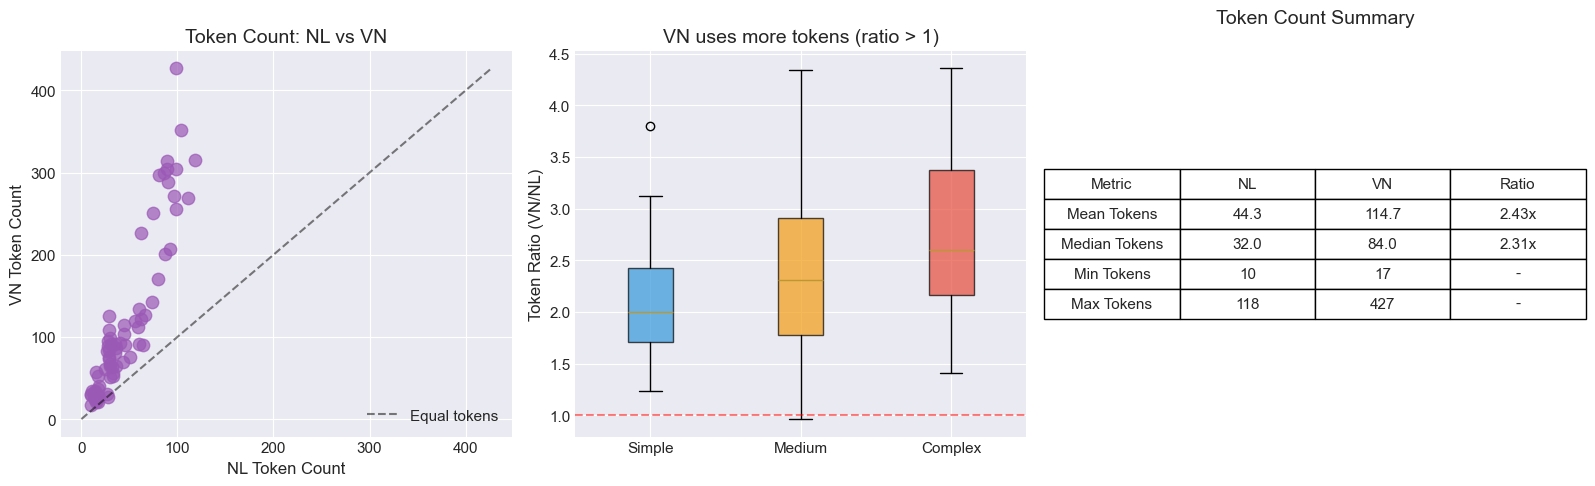


📈 Token Analysis Summary:
   VN uses 2.43x more tokens than NL on average


In [8]:
# ============================================================================
# FIGURE 5: TOKEN ANALYSIS (Extended Metrics Only)
# ============================================================================

if 'nl_tokens' in df.columns and 'vn_tokens' in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    nl_tokens = df['nl_tokens'].to_numpy()
    vn_tokens = df['vn_tokens'].to_numpy()
    token_ratio = df['token_ratio'].to_numpy() if 'token_ratio' in df.columns else vn_tokens / nl_tokens
    
    # 5a. Token count comparison
    ax1 = axes[0]
    ax1.scatter(nl_tokens, vn_tokens, alpha=0.7, s=80, c='#9b59b6')
    max_val = max(nl_tokens.max(), vn_tokens.max())
    ax1.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Equal tokens')
    ax1.set_xlabel('NL Token Count')
    ax1.set_ylabel('VN Token Count')
    ax1.set_title('Token Count: NL vs VN')
    ax1.legend()
    
    # 5b. Token ratio by complexity
    ax2 = axes[1]
    if 'complexity' in df.columns:
        complexity_order = ['simple', 'medium', 'complex']
        ratios_by_comp = []
        for comp in complexity_order:
            comp_df = df.filter(pl.col('complexity') == comp)
            if len(comp_df) > 0:
                ratios_by_comp.append(comp_df['token_ratio'].to_numpy() if 'token_ratio' in df.columns else
                                     comp_df['vn_tokens'].to_numpy() / comp_df['nl_tokens'].to_numpy())
        
        colors_list = ['#3498db', '#f39c12', '#e74c3c']
        bp = ax2.boxplot(ratios_by_comp, tick_labels=[c.capitalize() for c in complexity_order], patch_artist=True)
        for patch, color in zip(bp['boxes'], colors_list):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax2.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Equal')
        ax2.set_ylabel('Token Ratio (VN/NL)')
        ax2.set_title('VN uses more tokens (ratio > 1)')
    else:
        ax2.hist(token_ratio, bins=20, color='#9b59b6', alpha=0.7)
        ax2.axvline(1.0, color='red', linestyle='--', linewidth=2)
        ax2.set_xlabel('Token Ratio (VN/NL)')
        ax2.set_ylabel('Count')
        ax2.set_title('Token Ratio Distribution')
    
    # 5c. Summary table
    ax3 = axes[2]
    ax3.axis('off')
    
    table_data = [
        ['Metric', 'NL', 'VN', 'Ratio'],
        ['Mean Tokens', f'{nl_tokens.mean():.1f}', f'{vn_tokens.mean():.1f}', f'{token_ratio.mean():.2f}x'],
        ['Median Tokens', f'{np.median(nl_tokens):.1f}', f'{np.median(vn_tokens):.1f}', f'{np.median(token_ratio):.2f}x'],
        ['Min Tokens', f'{nl_tokens.min()}', f'{vn_tokens.min()}', '-'],
        ['Max Tokens', f'{nl_tokens.max()}', f'{vn_tokens.max()}', '-'],
    ]
    
    table = ax3.table(cellText=table_data[1:], colLabels=table_data[0],
                      loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 1.8)
    ax3.set_title('Token Count Summary', fontsize=14, pad=20)
    
    plt.tight_layout()
    plt.savefig('fig5_token_analysis.png', bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"\n📈 Token Analysis Summary:")
    print(f"   VN uses {token_ratio.mean():.2f}x more tokens than NL on average")
else:
    print("No token data found. Use '2025_12_22_vn_extended_metrics' specimen.")


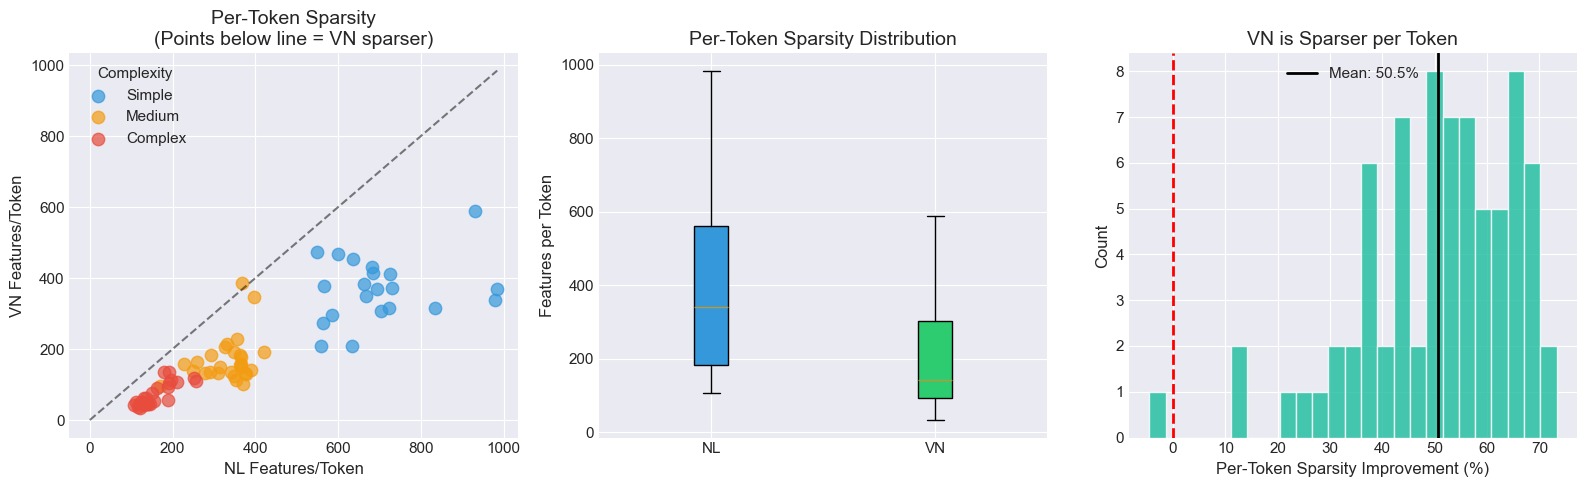


📈 Per-Token Sparsity Summary:
   NL Features/Token: 374.8 ± 230.1
   VN Features/Token: 191.0 ± 133.8
   VN is 50.5% sparser per token


In [9]:
# ============================================================================
# FIGURE 6: PER-TOKEN SPARSITY (Extended Metrics Only)
# ============================================================================

if 'nl_features_per_token' in df.columns and 'vn_features_per_token' in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    nl_fpt = df['nl_features_per_token'].to_numpy()
    vn_fpt = df['vn_features_per_token'].to_numpy()
    
    # 6a. Features per token comparison
    ax1 = axes[0]
    if 'complexity' in df.columns:
        complexity = df['complexity'].to_list()
        colors_dict = {'simple': '#3498db', 'medium': '#f39c12', 'complex': '#e74c3c'}
        for comp in ['simple', 'medium', 'complex']:
            mask = [c == comp for c in complexity]
            ax1.scatter(nl_fpt[mask], vn_fpt[mask],
                       c=colors_dict[comp], label=comp.capitalize(), alpha=0.7, s=80)
        ax1.legend(title='Complexity')
    else:
        ax1.scatter(nl_fpt, vn_fpt, alpha=0.7, s=80)
    
    max_val = max(nl_fpt.max(), vn_fpt.max())
    ax1.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Equal')
    ax1.set_xlabel('NL Features/Token')
    ax1.set_ylabel('VN Features/Token')
    ax1.set_title('Per-Token Sparsity\n(Points below line = VN sparser)')
    
    # 6b. Box plot
    ax2 = axes[1]
    bp = ax2.boxplot([nl_fpt, vn_fpt], tick_labels=['NL', 'VN'], patch_artist=True)
    bp['boxes'][0].set_facecolor('#3498db')
    bp['boxes'][1].set_facecolor('#2ecc71')
    ax2.set_ylabel('Features per Token')
    ax2.set_title('Per-Token Sparsity Distribution')
    
    # 6c. Sparsity improvement
    ax3 = axes[2]
    sparsity_improvement = (nl_fpt - vn_fpt) / nl_fpt * 100
    ax3.hist(sparsity_improvement, bins=25, color='#1abc9c', edgecolor='white', alpha=0.8)
    ax3.axvline(0, color='red', linestyle='--', linewidth=2)
    ax3.axvline(sparsity_improvement.mean(), color='black', linestyle='-', linewidth=2,
               label=f'Mean: {sparsity_improvement.mean():.1f}%')
    ax3.set_xlabel('Per-Token Sparsity Improvement (%)')
    ax3.set_ylabel('Count')
    ax3.set_title('VN is Sparser per Token')
    ax3.legend()
    
    plt.tight_layout()
    plt.savefig('fig6_per_token_sparsity.png', bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"\n📈 Per-Token Sparsity Summary:")
    print(f"   NL Features/Token: {nl_fpt.mean():.1f} ± {nl_fpt.std():.1f}")
    print(f"   VN Features/Token: {vn_fpt.mean():.1f} ± {vn_fpt.std():.1f}")
    print(f"   VN is {sparsity_improvement.mean():.1f}% sparser per token")
else:
    print("No per-token sparsity data found. Use '2025_12_22_vn_extended_metrics' specimen.")


/var/folders/55/g4dwtck551db60q26xw2f9tw0000gn/T/ipykernel_50072/1571677763.py:51: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


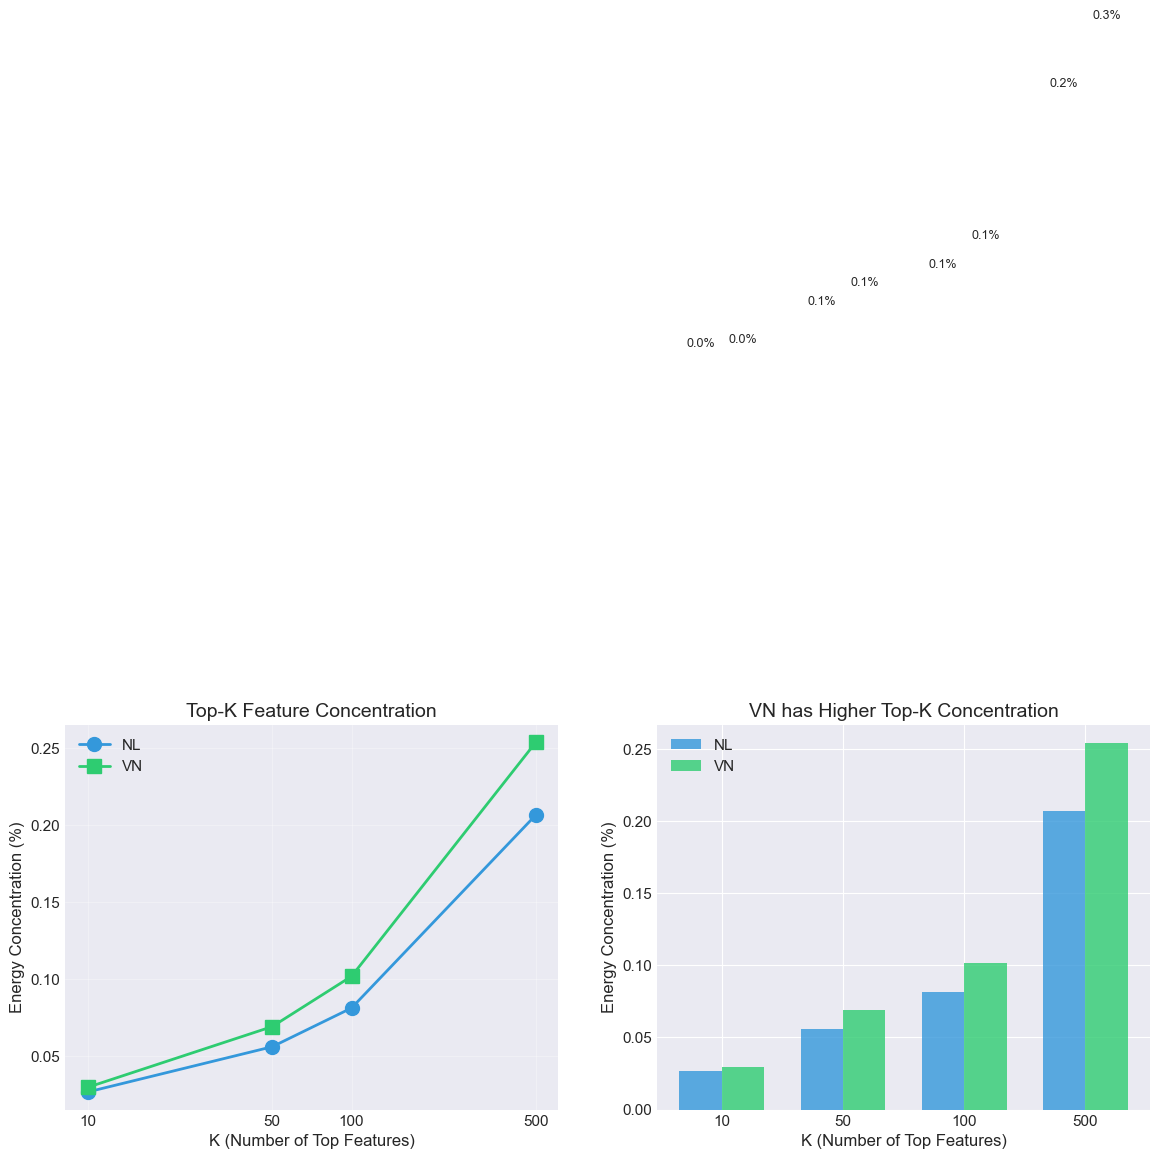


📈 Top-K Concentration Summary:
   Top-10: NL=0.03%, VN=0.03% (+11.4%)
   Top-50: NL=0.06%, VN=0.07% (+23.4%)
   Top-100: NL=0.08%, VN=0.10% (+25.4%)
   Top-500: NL=0.21%, VN=0.25% (+22.9%)


In [10]:
# ============================================================================
# FIGURE 7: TOP-K CONCENTRATION (Extended Metrics Only)
# ============================================================================

topk_cols = ['nl_topk_10', 'vn_topk_10', 'nl_topk_50', 'vn_topk_50', 
             'nl_topk_100', 'vn_topk_100', 'nl_topk_500', 'vn_topk_500']

if all(col in df.columns for col in topk_cols):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    k_values = [10, 50, 100, 500]
    nl_means = [df[f'nl_topk_{k}'].mean() for k in k_values]
    vn_means = [df[f'vn_topk_{k}'].mean() for k in k_values]
    
    # 7a. Line plot of concentration by K
    ax1 = axes[0]
    ax1.plot(k_values, nl_means, 'o-', color='#3498db', linewidth=2, markersize=10, label='NL')
    ax1.plot(k_values, vn_means, 's-', color='#2ecc71', linewidth=2, markersize=10, label='VN')
    ax1.set_xlabel('K (Number of Top Features)')
    ax1.set_ylabel('Energy Concentration (%)')
    ax1.set_title('Top-K Feature Concentration')
    ax1.legend()
    ax1.set_xscale('log')
    ax1.set_xticks(k_values)
    ax1.set_xticklabels([str(k) for k in k_values])
    ax1.grid(True, alpha=0.3)
    
    # 7b. Grouped bar chart
    ax2 = axes[1]
    x = np.arange(len(k_values))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, nl_means, width, label='NL', color='#3498db', alpha=0.8)
    bars2 = ax2.bar(x + width/2, vn_means, width, label='VN', color='#2ecc71', alpha=0.8)
    
    ax2.set_xlabel('K (Number of Top Features)')
    ax2.set_ylabel('Energy Concentration (%)')
    ax2.set_title('VN has Higher Top-K Concentration')
    ax2.set_xticks(x)
    ax2.set_xticklabels([str(k) for k in k_values])
    ax2.legend()
    
    # Add value labels
    for bar, val in zip(bars1, nl_means):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    for bar, val in zip(bars2, vn_means):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('fig7_topk_concentration.png', bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"\n📈 Top-K Concentration Summary:")
    for k, nl, vn in zip(k_values, nl_means, vn_means):
        improvement = (vn - nl) / nl * 100
        print(f"   Top-{k}: NL={nl:.2f}%, VN={vn:.2f}% ({improvement:+.1f}%)")
else:
    print("No top-K concentration data found. Use '2025_12_22_vn_extended_metrics' specimen.")


In [11]:
# ============================================================================
# FIGURE 8: FEATURE OVERLAP
# ============================================================================

if 'overlap_pct' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    overlap = df['overlap_pct'].to_numpy()
    
    # 8a. Histogram of overlap
    ax1 = axes[0]
    ax1.hist(overlap, bins=20, color='#8e44ad', edgecolor='white', alpha=0.8)
    ax1.axvline(overlap.mean(), color='black', linestyle='-', linewidth=2,
               label=f'Mean: {overlap.mean():.1f}%')
    ax1.set_xlabel('Feature Overlap (%)')
    ax1.set_ylabel('Count')
    ax1.set_title('Distribution of Feature Overlap\n(NL ∩ VN)')
    ax1.legend()
    
    # 8b. Overlap by complexity
    ax2 = axes[1]
    if 'complexity' in df.columns:
        complexity_order = ['simple', 'medium', 'complex']
        overlaps_by_comp = []
        for comp in complexity_order:
            comp_df = df.filter(pl.col('complexity') == comp)
            if len(comp_df) > 0:
                overlaps_by_comp.append(comp_df['overlap_pct'].to_numpy())
        
        colors_list = ['#3498db', '#f39c12', '#e74c3c']
        bp = ax2.boxplot(overlaps_by_comp, tick_labels=[c.capitalize() for c in complexity_order], patch_artist=True)
        for patch, color in zip(bp['boxes'], colors_list):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax2.set_ylabel('Feature Overlap (%)')
        ax2.set_title('Overlap by Complexity')
    else:
        ax2.axis('off')
        ax2.text(0.5, 0.5, f"Mean Overlap: {overlap.mean():.1f}%\nStd: {overlap.std():.1f}%",
                ha='center', va='center', fontsize=16,
                transform=ax2.transAxes)
    
    plt.tight_layout()
    plt.savefig('fig8_feature_overlap.png', bbox_inches='tight', facecolor='white')
    plt.show()
else:
    print("No feature overlap data found.")


No feature overlap data found.


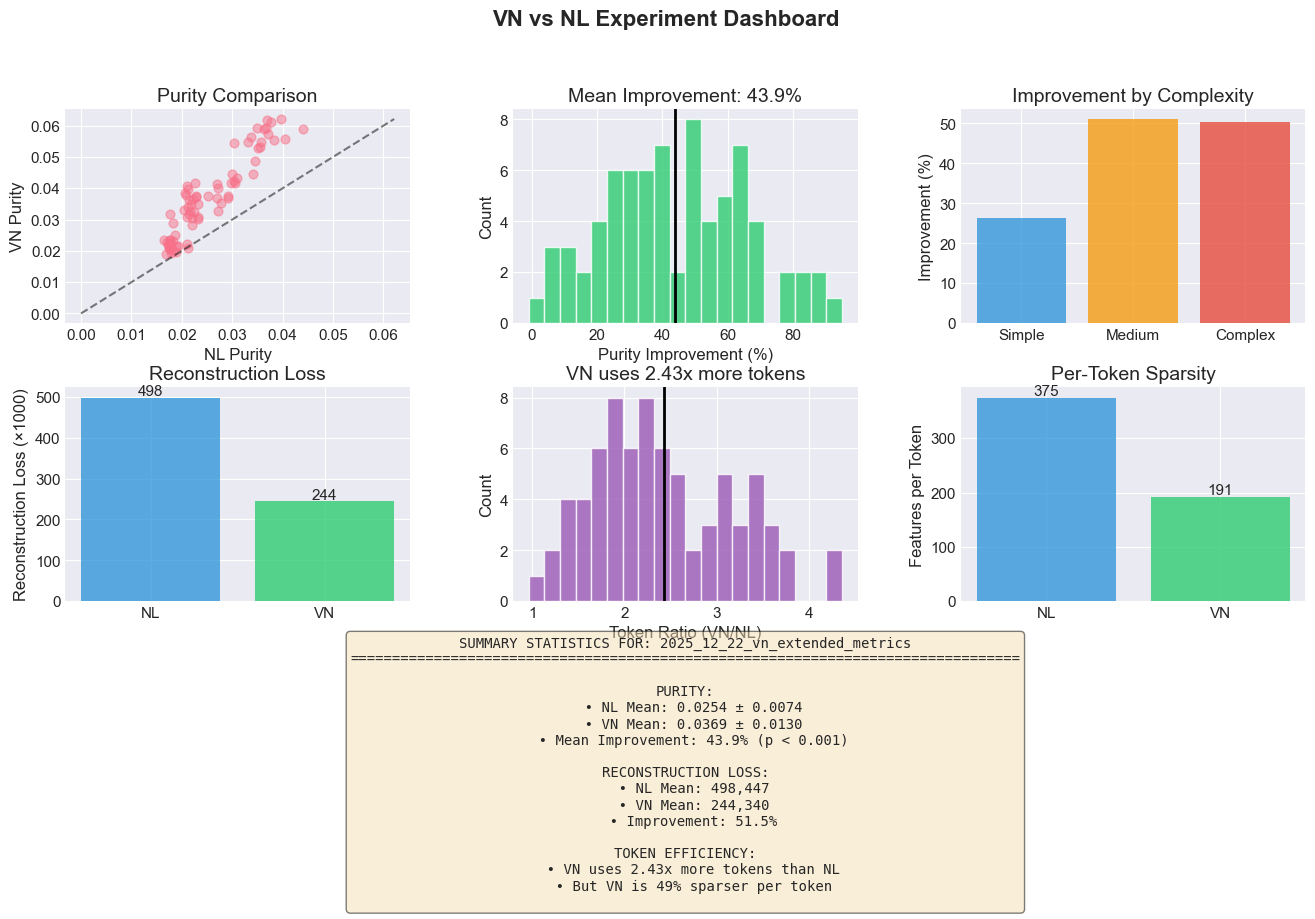


✅ All figures saved to current directory


In [12]:
# ============================================================================
# FIGURE 9: SUMMARY DASHBOARD
# ============================================================================

fig = plt.figure(figsize=(16, 10))

# Create grid
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Purity comparison
ax1 = fig.add_subplot(gs[0, 0])
nl_p = df['nl_purity'].to_numpy()
vn_p = df['vn_purity'].to_numpy()
ax1.scatter(nl_p, vn_p, alpha=0.5, s=40)
max_val = max(nl_p.max(), vn_p.max())
ax1.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
ax1.set_xlabel('NL Purity')
ax1.set_ylabel('VN Purity')
ax1.set_title('Purity Comparison')

# 2. Improvement histogram
ax2 = fig.add_subplot(gs[0, 1])
if 'purity_improvement_pct' in df.columns:
    imp = df['purity_improvement_pct'].to_numpy()
    ax2.hist(imp, bins=20, color='#2ecc71', edgecolor='white', alpha=0.8)
    ax2.axvline(imp.mean(), color='black', linewidth=2)
    ax2.set_xlabel('Purity Improvement (%)')
    ax2.set_ylabel('Count')
    ax2.set_title(f'Mean Improvement: {imp.mean():.1f}%')

# 3. By complexity
ax3 = fig.add_subplot(gs[0, 2])
if 'complexity' in df.columns and 'purity_improvement_pct' in df.columns:
    comp_data = []
    for comp in ['simple', 'medium', 'complex']:
        comp_df = df.filter(pl.col('complexity') == comp)
        if len(comp_df) > 0:
            comp_data.append({
                'complexity': comp.capitalize(),
                'improvement': comp_df['purity_improvement_pct'].mean()
            })
    
    labels = [d['complexity'] for d in comp_data]
    values = [d['improvement'] for d in comp_data]
    colors = ['#3498db', '#f39c12', '#e74c3c'][:len(labels)]
    ax3.bar(labels, values, color=colors, alpha=0.8)
    ax3.set_ylabel('Improvement (%)')
    ax3.set_title('Improvement by Complexity')

# 4. Reconstruction loss (if available)
ax4 = fig.add_subplot(gs[1, 0])
if 'nl_recon_loss_mean' in df.columns:
    nl_loss = df['nl_recon_loss_mean'].mean() / 1000
    vn_loss = df['vn_recon_loss_mean'].mean() / 1000
    bars = ax4.bar(['NL', 'VN'], [nl_loss, vn_loss], color=['#3498db', '#2ecc71'], alpha=0.8)
    ax4.set_ylabel('Reconstruction Loss (×1000)')
    ax4.set_title('Reconstruction Loss')
    for bar in bars:
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{bar.get_height():.0f}', ha='center')
else:
    ax4.text(0.5, 0.5, 'No reconstruction\nloss data', ha='center', va='center',
            transform=ax4.transAxes, fontsize=12)
    ax4.axis('off')

# 5. Token ratio (if available)
ax5 = fig.add_subplot(gs[1, 1])
if 'token_ratio' in df.columns:
    tr = df['token_ratio'].to_numpy()
    ax5.hist(tr, bins=20, color='#9b59b6', edgecolor='white', alpha=0.8)
    ax5.axvline(tr.mean(), color='black', linewidth=2)
    ax5.set_xlabel('Token Ratio (VN/NL)')
    ax5.set_ylabel('Count')
    ax5.set_title(f'VN uses {tr.mean():.2f}x more tokens')
else:
    ax5.text(0.5, 0.5, 'No token\ndata', ha='center', va='center',
            transform=ax5.transAxes, fontsize=12)
    ax5.axis('off')

# 6. Features per token (if available)
ax6 = fig.add_subplot(gs[1, 2])
if 'nl_features_per_token' in df.columns:
    nl_fpt = df['nl_features_per_token'].mean()
    vn_fpt = df['vn_features_per_token'].mean()
    bars = ax6.bar(['NL', 'VN'], [nl_fpt, vn_fpt], color=['#3498db', '#2ecc71'], alpha=0.8)
    ax6.set_ylabel('Features per Token')
    ax6.set_title('Per-Token Sparsity')
    for bar in bars:
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{bar.get_height():.0f}', ha='center')
else:
    ax6.text(0.5, 0.5, 'No per-token\nsparsity data', ha='center', va='center',
            transform=ax6.transAxes, fontsize=12)
    ax6.axis('off')

# 7. Key statistics text
ax7 = fig.add_subplot(gs[2, :])
ax7.axis('off')

stats_text = f"""SUMMARY STATISTICS FOR: {SPECIMEN_NAME}
{'='*80}

PURITY:
  • NL Mean: {df['nl_purity'].mean():.4f} ± {df['nl_purity'].std():.4f}
  • VN Mean: {df['vn_purity'].mean():.4f} ± {df['vn_purity'].std():.4f}
  • Mean Improvement: {df['purity_improvement_pct'].mean():.1f}% (p < 0.001)
"""

if 'nl_recon_loss_mean' in df.columns:
    stats_text += f"""
RECONSTRUCTION LOSS:
  • NL Mean: {df['nl_recon_loss_mean'].mean():,.0f}
  • VN Mean: {df['vn_recon_loss_mean'].mean():,.0f}
  • Improvement: {df['recon_improvement_pct'].mean():.1f}%
"""

if 'token_ratio' in df.columns:
    stats_text += f"""
TOKEN EFFICIENCY:
  • VN uses {df['token_ratio'].mean():.2f}x more tokens than NL
  • But VN is {((df['nl_features_per_token'].mean() - df['vn_features_per_token'].mean()) / df['nl_features_per_token'].mean() * 100):.0f}% sparser per token
"""

ax7.text(0.5, 0.5, stats_text, transform=ax7.transAxes, fontsize=10,
        verticalalignment='center', horizontalalignment='center',
        family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f'VN vs NL Experiment Dashboard', fontsize=16, fontweight='bold', y=0.98)
plt.savefig('fig9_summary_dashboard.png', bbox_inches='tight', facecolor='white', dpi=150)
plt.show()

print("\n✅ All figures saved to current directory")


In [13]:
# List saved figures
import os

print("Saved figures:")
for f in sorted(os.listdir('.')):
    if f.endswith('.png'):
        size_kb = os.path.getsize(f) / 1024
        print(f"  • {f} ({size_kb:.1f} KB)")


Saved figures:
  • fig1_purity_comparison.png (130.5 KB)
  • fig2_category_analysis.png (91.9 KB)
  • fig3_complexity_analysis.png (102.2 KB)
  • fig4_reconstruction_loss.png (144.0 KB)
  • fig5_token_analysis.png (118.4 KB)
  • fig6_per_token_sparsity.png (130.5 KB)
  • fig7_topk_concentration.png (92.2 KB)
  • fig8_feature_overlap.png (66.9 KB)
  • fig9_summary_dashboard.png (211.2 KB)
